In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


NOTE: This notebook can be run from a later step, but some cells are crucial to run before others. If you want to run the notebook from a later step, make sure to run the cells specified in the previous steps first. This is just below each heading in the parentheses!


# Step 1: Gathering the data
(You can skip to the next step if you already have the parquets in floor)

Before we can start to play with the data, we need to gather it. The data is stored in a MongoDB database. The `loader.py` script will load the data from the database, apply the transformers and save the result to a file. The transformers are defined in the `transformers` directory.

The loader can be run from the command line, or we can import it as a module and use it in a notebook. It can either use cached data, which is stored in the `cache` directory once it has been loaded from the database, or it can load the data from the database directly. To load from the database, pass the `--cache-mode` or `-c` option to the CLI or use the `cache_mode` argument when running the loader's `run()` function. Possible values are `auto`, `force-local`, and `force-refresh`.

In [6]:
from loader import run
need_to_gather_data = False # set to True to rebuild the data parquet files
use_fresh_data = True # set to True to use the latest data from DB
if need_to_gather_data:
    mode = 'force-refresh' if use_fresh_data else 'auto'
    run(cache_mode=mode)

# Step 2: Training
(You can run only the next two cells and skip to the next step if you already have the model pickled)

Once the loader has loaded the data and applied the transformations, we can load the resulting parquets and prepare for model training. We then split the data into training and test sets and train a model.

In [7]:
feature_to_drop = "DEFAULT"

In [8]:
import pyarrow as pa
import pyarrow.parquet as pq
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas.api.types")
warnings.filterwarnings("ignore", message="is_sparse is deprecated", category=FutureWarning)
warnings.filterwarnings("ignore", message="is_categorical_dtype is deprecated", category=FutureWarning)


phishing = pq.read_table('floor/phishing_2307.parquet')
#benign = pq.read_table('floor/cesnet_2307.parquet')
#benign = pq.read_table('floor/benign_2307.parquet')

#benign = pq.read_table('floor/cesnet2.parquet')
benign = pq.read_table('floor/benign_cesnet_union_2307.parquet')
# benign = pq.read_table('floor/cesnet2.parquet')

phishing_domain_names = phishing['domain_name']
benign_domain_names = benign['domain_name']

phishing_len = len(phishing_domain_names)
benign_len = len(benign_domain_names)

from transformers.drop_nontrain import drop_nontrain_table as drop_nontrain
phishing = drop_nontrain(phishing)
benign = drop_nontrain(benign)

# realign schemas (parquet files save in nonsense orders)
benign = benign.cast(phishing.schema)

# concatentate tables
data = pa.concat_tables([phishing, benign])
df = data.to_pandas()

from transformers.cast_timestamp import cast_timestamp
df = cast_timestamp(df)

#df["registrant_name_len"] = df["registrant_name_len"].astype(float)
#df["registrant_name_hash"] = df["registrant_name_hash"].astype(float)
#df["administrative_name_len"] = df["administrative_name_len"].astype(float)
#df["administrative_name_hash"] = df["administrative_name_hash"].astype(float)


#uncomment this, when running feature engineering script
#default is only the first run, so we can compare the results
if feature_to_drop != "DEFAULT":
    df = df.drop(columns=feature_to_drop)

#drop tls root cert lifetime
# df = df.drop(columns=['rdap_domain_age'])
# df = df.drop(columns=['tls_root_cert_lifetime'])
# df = df.drop(columns=['rdap_domain_active_time'])
# df = df.drop(columns=['rdap_time_from_last_change'])
#print all columns names
for col in df.columns:
    print(col)
df.head()

label
dns_has_dnskey
dns_A_count
dns_AAAA_count
dns_MX_count
dns_NS_count
dns_TXT_count
dns_SOA_count
dns_CNAME_count
dns_dn_level
dns_zone_level
dns_zone_digit_count
dns_zone_len
dns_zone_entropy
dns_resolved_record_types
dns_dnssec_score
dns_ttl_mean
dns_ttl_stdev
dns_ttl_low
dns_ttl_mid
dns_ttl_distinct_count
dns_soa_primary_ns_level
dns_soa_primary_ns_digit_count
dns_soa_primary_ns_len
dns_soa_primary_ns_entropy
dns_soa_email_level
dns_soa_email_digit_count
dns_soa_email_len
dns_soa_email_entropy
dns_soa_serial
dns_soa_refresh
dns_soa_retry
dns_soa_expire
dns_soa_min_ttl
dns_domain_name_in_mx
dns_mx_mean_len
dns_mx_mean_entropy
dns_txt_mean_entropy
dns_txt_external_verification_score
dns_txt_spf_exists
dns_txt_dkim_exists
dns_txt_dmarc_exists
dns_bigram_matches
dns_trigram_matches
ip_count
ip_mean_average_rtt
ip_a_ratio
ip_entropy
ip_as_address_entropy
ip_asn_entropy
ip_distinct_as_count
tls_CA_certs_in_chain_ratio
tls_broken_chain
tls_chain_len
tls_cipher_id
tls_client_auth_crt_co

,label,dns_has_dnskey,dns_A_count,dns_AAAA_count,dns_MX_count,dns_NS_count,dns_TXT_count,dns_SOA_count,dns_CNAME_count,dns_dn_level,...,ip_v4_count,ip_v6_count,rdap_ip_first_administrative_name_len,rdap_ip_first_administrative_name_hash,rdap_ip_first_administrative_email_len,rdap_ip_first_administrative_email_hash,rdap_ip_shortest_v4_prefix_len,rdap_ip_longest_v4_prefix_len,rdap_ip_shortest_v6_prefix_len,rdap_ip_longest_v6_prefix_len
0,misp_2307:phishing,0.0,2,0,0,0,0,0,0,1,...,2,0,13,801096893,23,1884044514,10,12,0,0
1,misp_2307:phishing,0.0,1,0,0,0,0,0,0,2,...,1,0,0,0,0,0,22,22,0,0
2,misp_2307:phishing,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,misp_2307:phishing,0.0,0,0,0,0,0,0,1,1,...,1,0,19,2019899649,23,397424728,24,24,0,0
4,misp_2307:phishing,0.0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,29,29,0,0


In [9]:
# create train and test sets
from config import Config
from sklearn.model_selection import train_test_split

#TODO extract label names from config files
# benign_label = list(Config.COLLECTIONS.keys())[0]
# misp_label = list(Config.COLLECTIONS.keys())[1]
class_map = {"benign_cesnet_union_2307:unknown": 0, "misp_2307:phishing": 1}
#class_map = {"cesnet2:unknown": 0, "misp_2307:phishing": 1}

labels = df['label'].apply(lambda x: class_map[x]) # y vector
features = df.drop('label', axis=1).copy() # X matrix

X_train, X_test, y_train, y_test = train_test_split(
  features,
  labels,
  test_size=0.3,
  random_state=42,
  shuffle=True, 
  stratify=labels
)

In [10]:
from xgboost import XGBClassifier
# uncomment the two disabled lines to use GPU
params = {
    "max_depth": 9,
    "eta": 0.15,
    "objective": "binary:logistic",
    # "tree_method": "gpu_hist",
    "min_child_weight": 2.0,
    "subsample": 0.6,
    # "sampling_method": "gradient_based",
    "alpha": 0,
    "gamma": 0.1,
    "lambda": 1.0,
    "max_delta_step": 0,
    "grow_policy": "lossguide",
    "max_bin": 512,
}
trees = 270

model = XGBClassifier(
  **params,
  n_estimators=trees,
  eval_metric=["error", "logloss", "auc"]
)

# set to True to cross validate
do_cross_val = False
if do_cross_val:
  from sklearn.model_selection import StratifiedKFold
  from sklearn.model_selection import cross_val_score
  kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
  results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
  print("F1: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

# at last, train the model
eval_set = [(X_train, y_train), (X_test, y_test)]
_ = model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

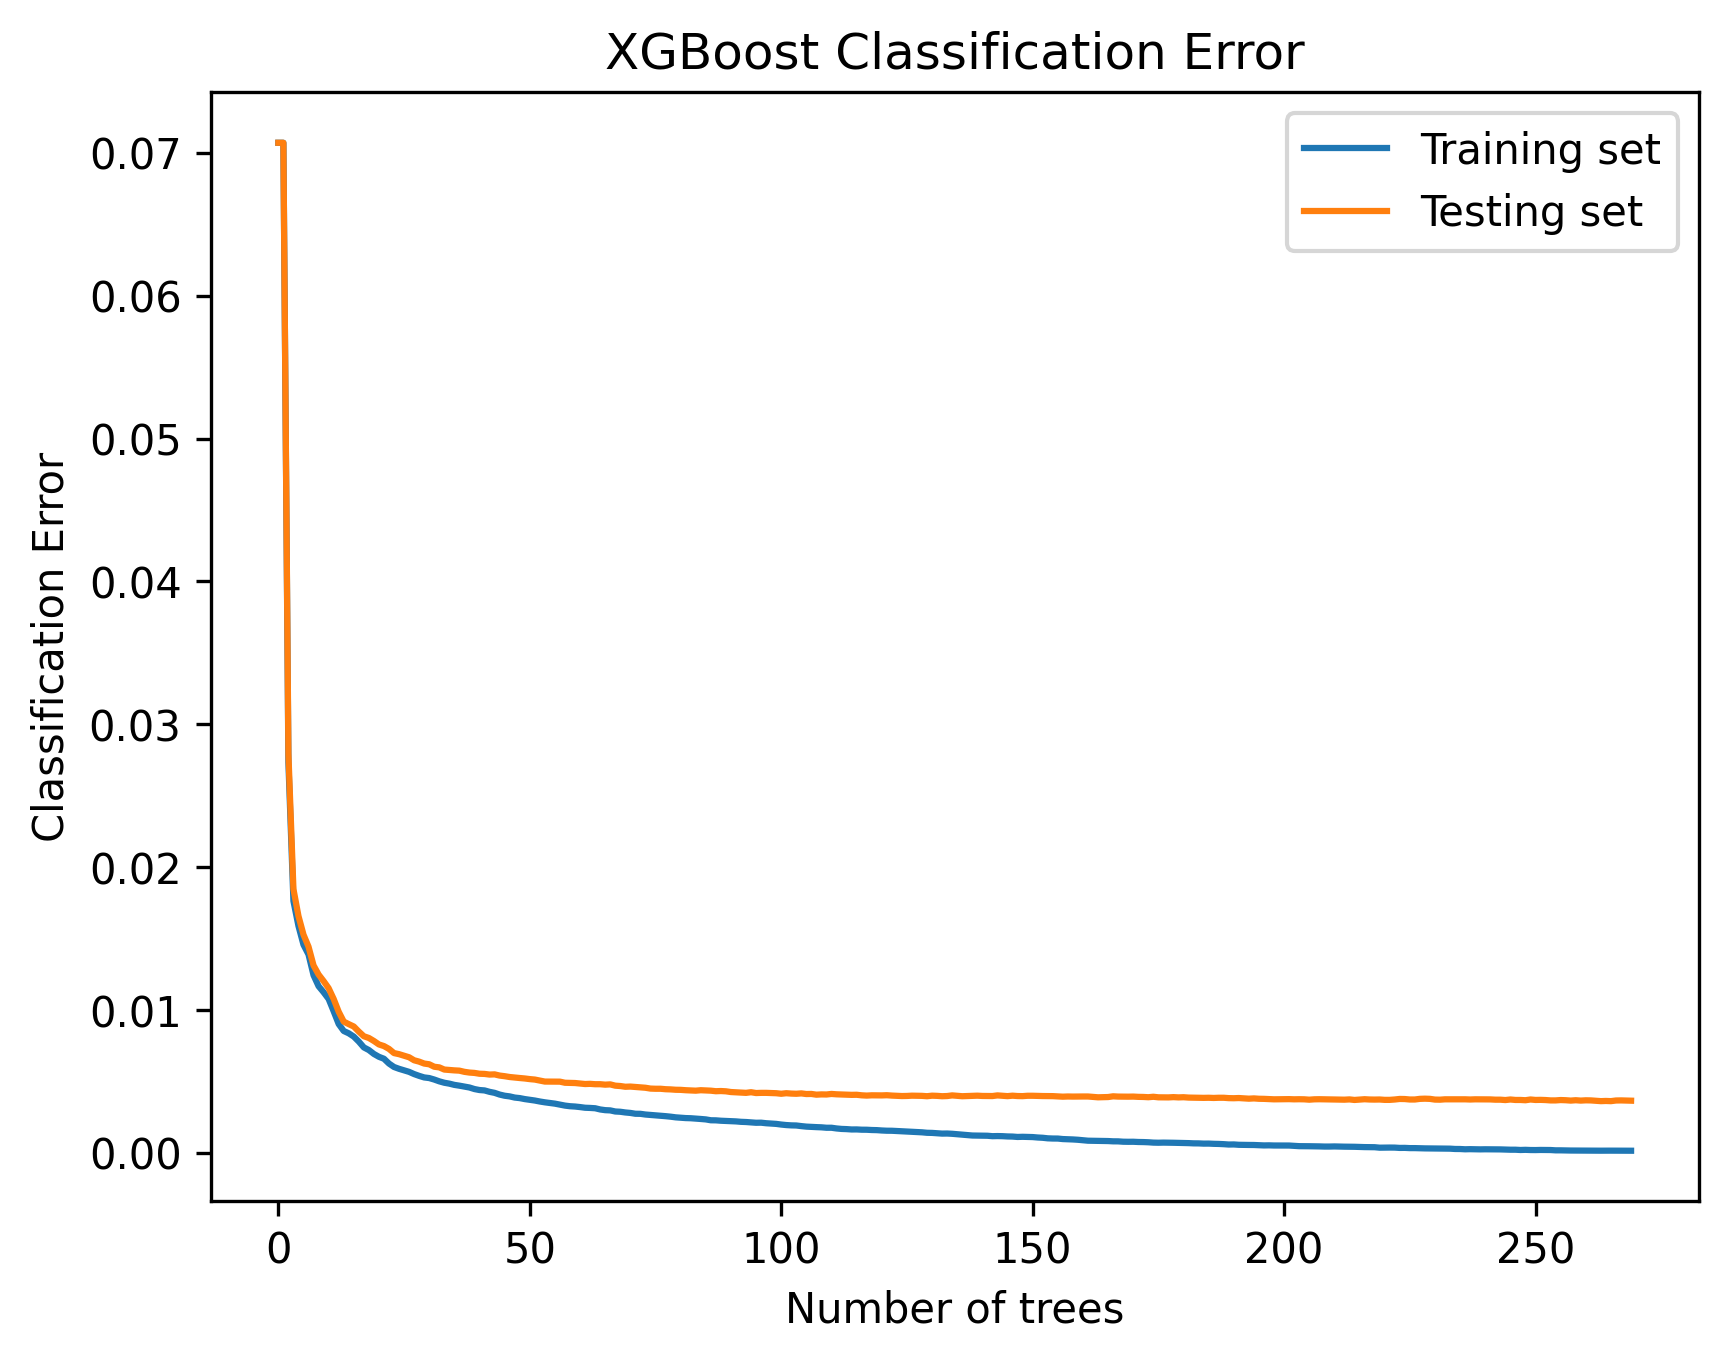

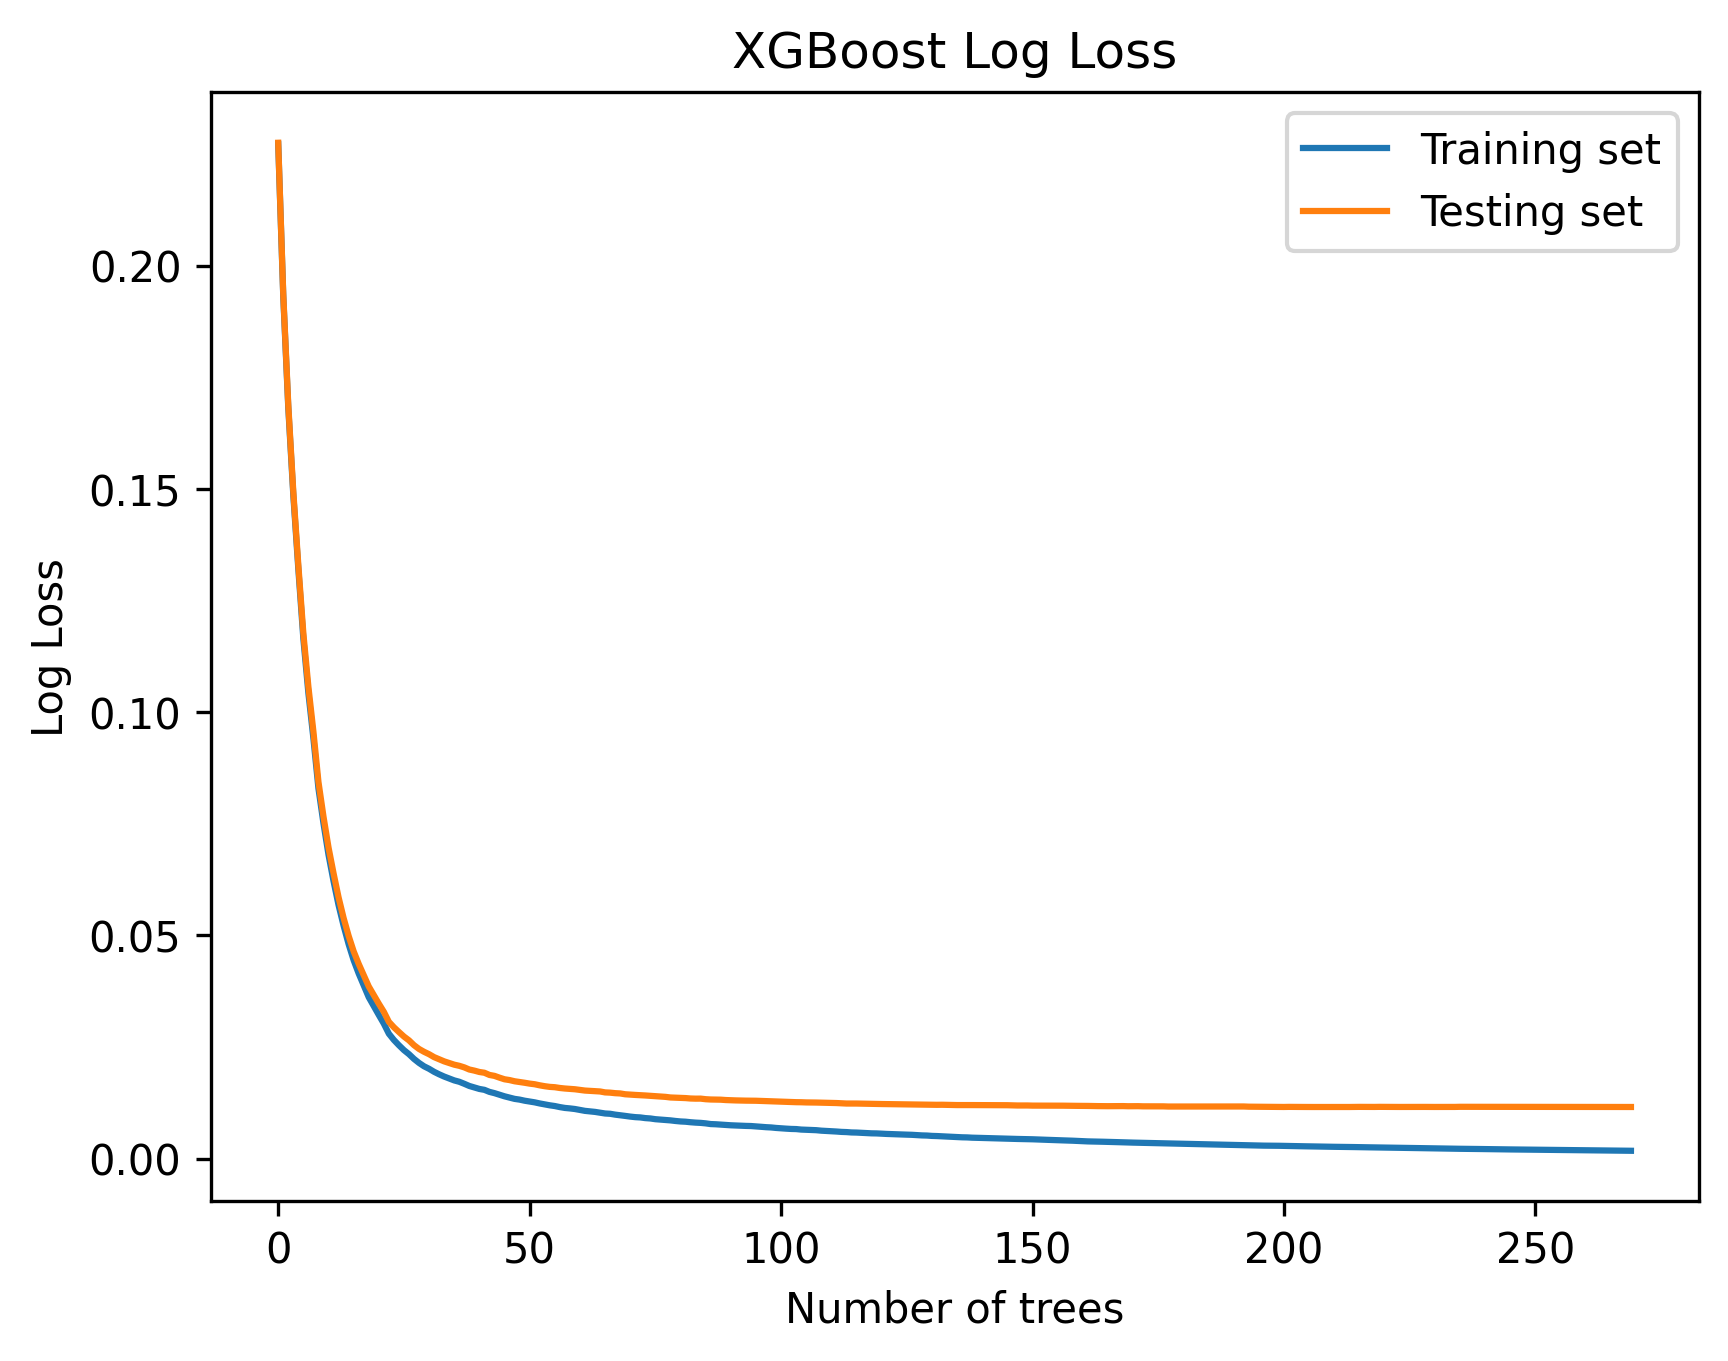

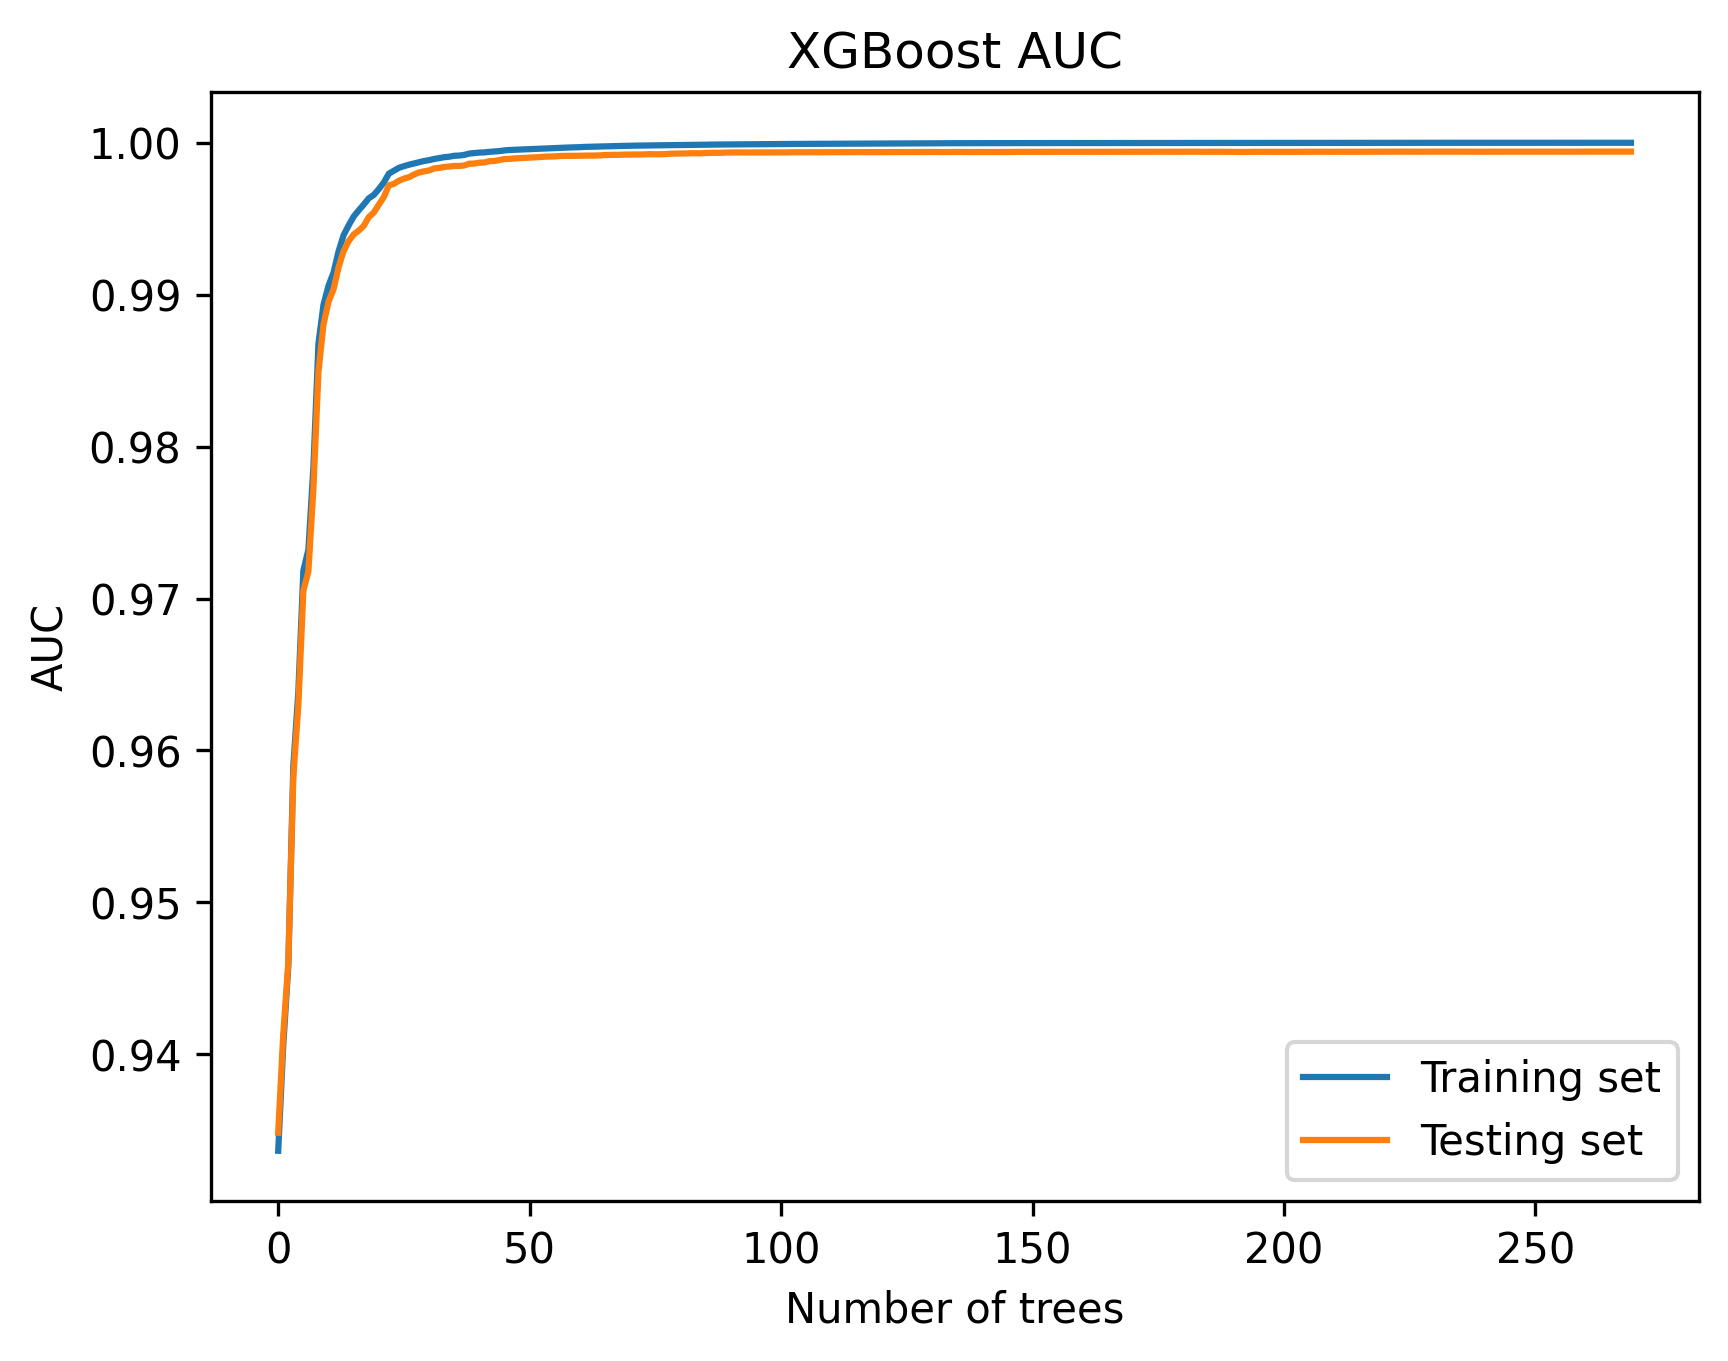

In [11]:
# plot evaluation
results = model.evals_result()
trees = len(results['validation_0']['error'])
x_axis = range(0, trees)

def plot_metric(metric):
    import matplotlib.pyplot as plt
    plt.rcParams["figure.dpi"] = 300
    #
    plt.plot(x_axis, results['validation_0'][metric], label='Training set')
    plt.plot(x_axis, results['validation_1'][metric], label='Testing set')
    plt.legend()
    mnames = {'error': 'Classification Error', 'logloss': 'Log Loss', 'auc': 'AUC'}
    mname = mnames[metric]
    plt.ylabel(mname)
    plt.xlabel('Number of trees')
    plt.title('XGBoost ' + mname)
    plt.show()

plot_metric('error')
plot_metric('logloss')
plot_metric('auc')

If you want to find the optimal set of hyperparameters (that is, the parameters for the model itself), you can use grid search. This will try all combinations of the parameters you specify and return the best one. This is a computationally expensive process, so it is recommended to run it on a machine with a GPU. The following cell shows a grid search, but is disabled by default. If you want to run it, set `run_grid_search` to `True`.

In [12]:
"""
# Hyperparameter tuning
run_grid_search = True
if run_grid_search:
    import pandas as pd
    from sklearn.model_selection import train_test_split
    class_map = {"benign_cesnet_union_2307:unknown": 0, "misp_2307:phishing": 1}
    labels = df['label'].apply(lambda x: class_map[x])
    features = df.drop('label', axis=1).copy()
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels)

    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import StratifiedKFold
    from xgboost import XGBClassifier

    params = {
        "eta": 0.15,
        "objective": "binary:logistic",
        "tree_method": "gpu_hist",
        #"predictor": "gpu_predictor"
    }
    trees = 240

    clf = XGBClassifier(**params)

    # this is your grid of parameters to search through, every combination will be tried
    grid = {
        "max_depth": [9],
        "min_child_weight": [2],
        "sampling_method": ["gradient_based"],
        "subsample": [0.6],
        "gamma": [0.1],
        "grow_policy": ["lossguide"],
        "max_bin": [512],
        "n_estimators": [270,280,290],
        "lambda": [1.0],
        "alpha": [0.0]
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    grid_search = GridSearchCV(
        estimator=clf,
        param_grid=grid,
        #n_jobs=-1,
        cv=cv,
        scoring='neg_log_loss',#'f1',
        verbose=3,
        return_train_score=True
    )

    grid_search.fit(X_train, y_train)

    clf = grid_search.best_estimator_

    scores = pd.DataFrame(grid_search.cv_results_)
    col_names = ['mean_train_score', 'mean_test_score']

    scores = pd.DataFrame(grid_search.cv_results_)

    from numpy import array
    from numpy.ma import masked_array

    col_names = ['mean_train_score', 'mean_test_score']
    means_df = scores[col_names]
    ax = means_df.plot(kind='line', grid=True)


    from matplotlib import pyplot as plt
    plt.rcParams["figure.figsize"] = [12, 12]
    plt.rcParams["figure.autolayout"] = True

    plt.rcParams["figure.dpi"] = 300

    max_ids = means_df.idxmax(axis=0)

    for i in range(len(max_ids)):
        for col_name in col_names:
            value = means_df[col_name][max_ids[i]]
            id = max_ids[i]
            
            color = 'r' if max_ids[i] == max_ids['mean_test_score'] else 'grey'
            
            ax.scatter([id], [value],
                      marker='o',
                      color=color,
                      label='point',)

            ax.annotate(str(round(value, 3))+"_ID="+str(id),
                        (id, value),
                        xytext=(id+3, value))
            
    print(scores)
"""

'\n# Hyperparameter tuning\nrun_grid_search = True\nif run_grid_search:\n    import pandas as pd\n    from sklearn.model_selection import train_test_split\n    class_map = {"benign_cesnet_union_2307:unknown": 0, "misp_2307:phishing": 1}\n    labels = df[\'label\'].apply(lambda x: class_map[x])\n    features = df.drop(\'label\', axis=1).copy()\n    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels)\n\n    from sklearn.model_selection import GridSearchCV\n    from sklearn.model_selection import StratifiedKFold\n    from xgboost import XGBClassifier\n\n    params = {\n        "eta": 0.15,\n        "objective": "binary:logistic",\n        "tree_method": "gpu_hist",\n        #"predictor": "gpu_predictor"\n    }\n    trees = 240\n\n    clf = XGBClassifier(**params)\n\n    # this is your grid of parameters to search through, every combination will be tried\n    grid = {\n        "max_depth": [9],\n        "min_c

In [13]:
"""
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
scores
"""


"\npd.set_option('display.max_columns', None)\npd.set_option('display.max_rows', None)\nscores\n"

Either way, now you should have a trained model ready to use. Let's save it first, so we can use it later.

In [14]:
import pickle
pickle.dump(model, open("xgboost_model.pickle.dat", "wb"))

# Step 3: Evaluating the model's performance
(You can run the next cell only and then skip to the next step if you just want to play with SHAP)

We can now load the model at any time and use it to make predictions. We can also evaluate its performance on the test set. The following cell will load the model and evaluate it on the test set. It will also print the confusion matrix and classification report.

In [15]:
import pickle
model = pickle.load(open("xgboost_model.pickle.dat", "rb"))

0.9739082919721325


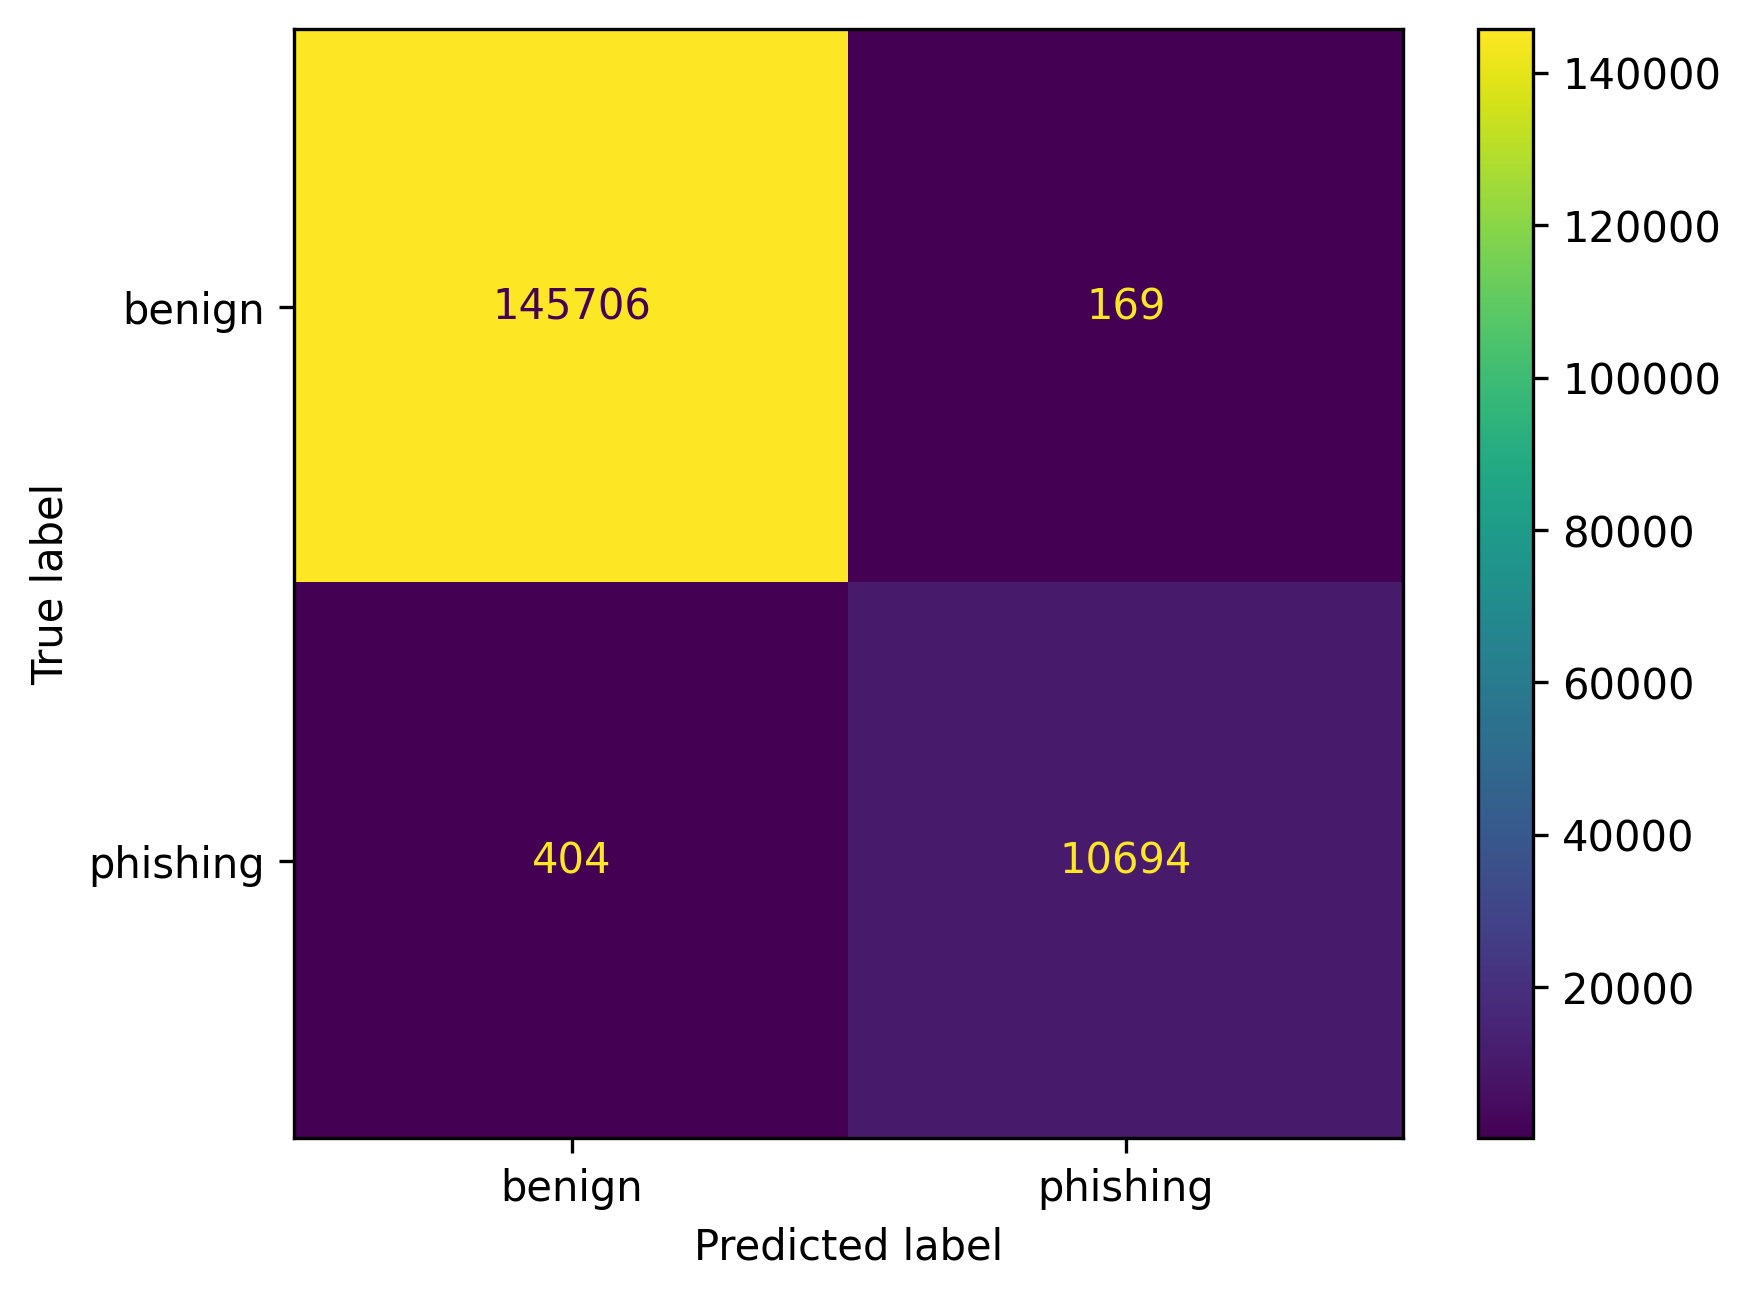

In [16]:
import os
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

predicted = model.predict(X_test)
print(f1_score(y_test, predicted))


#create folder if not exists
if not os.path.exists('false_positives/images'):
    os.makedirs('false_positives/images')

confusion_matrix = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=['benign', 'phishing'], values_format='d')
#save confusion matrix as pdf to false_positives/images
confusion_matrix.figure_.savefig('false_positives/images/confusion_matrix.pdf', bbox_inches='tight')



In [17]:
from sklearn.metrics import confusion_matrix
import os
import pandas as pd

# Extract values from confusion matrix
confusion_matrix_result = confusion_matrix(y_test, predicted)
TN, FP, FN, TP = confusion_matrix_result.ravel()
# FP = confusion_matrix_result[0][1]

# Get the indices of false positive instances
false_positive_indices = (predicted == 1) & (y_test == 0)
false_positive_domains = X_test[false_positive_indices]

#converting domains to a list of strings
false_positive_domains_list = false_positive_domains.index.map(str).tolist()


df_false_positives = df.iloc[false_positive_domains_list].to_csv('false_positives/false_positive_df.csv', sep='\t')

#convert false_positive_domains_list back to ints
false_positive_domains_list = [int(i) for i in false_positive_domains_list]


#from each number in false_positive_domains_list substract len of phishing domains, because false positives are only in benign for now
false_positive_domains_list = [i - phishing_len for i in false_positive_domains_list]
domain_names = benign_domain_names.to_pandas().iloc[false_positive_domains_list]


#create dictionary from domain_names with format index as key and domain as value
domain_names_dict = domain_names.to_dict()
#to each index of this dict add len of phishing domains, because false positives are only in benign for now
domain_names_dict = {int(k): v for k, v in domain_names_dict.items()}
domain_names_dict = {v: k + phishing_len for k, v in domain_names_dict.items()}
print(domain_names_dict)

#read df_false_positives csv file and add column domain_name to each row with value based on index from domain_names_dict
df_false_positives = pd.read_csv('false_positives/false_positive_df.csv', sep='\t')
os.remove('false_positives/false_positive_df.csv')

#print key for each row in df_false_positives
for index, row in df_false_positives.iterrows():
    index_value = row['Unnamed: 0']
    key = list(domain_names_dict.keys())[list(domain_names_dict.values()).index(index_value)]
    df_false_positives.at[index, 'domain_name'] = key

#move column domain_name to the first position
df_false_positives = df_false_positives[['domain_name'] + [col for col in df_false_positives.columns if col != 'domain_name']]

df_false_positives.to_excel('false_positives/FP.xlsx', index=False)
print(df_false_positives.head(1))



{'s.ktxtr.com': 380626, 'ibaraki-84764.herokussl.com': 229014, 'cooooos.com': 139388, 'api.wmkankan.com': 77925, 'os-api.test.os.qkcorp.net': 323668, 'dajak.vafrike.ru': 148796, 'stra.hasmobi.net': 418141, 'skyworthdigital.sjxrbj.com': 400667, 'games4.qqgametimes.com': 207223, 'auth.merrillcorp.com': 89950, 'airasia.gw-dv.net': 62650, 'airportus.info': 62809, 'torrentsnows.com': 433772, 'one.exness.link': 320288, 'www.manpower.gov.om': 495249, 'cflare.io': 123138, 'matomo.mp3y.download': 277998, 'api.video.browser.tvall.cn': 77640, 'awrcaverybrstuktdybstr.com': 92342, 'www.estrenospapaya.com': 485019, 'stun.zmzfile.com': 419293, 'onlineworkplace24.de': 321480, 'deliciouscheesesfromfrance.com': 153063, 'yeeterracing.com': 518379, 'theirving.net': 429246, 'awecerybtuitbyatr.com': 92267, 'rplnd5.com': 367889, 'gm2.iinmobi.com': 212757, 'eservices.manpower.gov.om': 180345, 'pthikitpet.com': 349049, 'mail.wavela.bid': 274670, 'torrentz2.eu': 433784, 'tcs-japan.co.jp': 426050, 'time.alcanet.

/tmp/ipykernel_357604/3482792637.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 's.ktxtr.com' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_false_positives.at[index, 'domain_name'] = key


   domain_name  Unnamed: 0                             label  dns_has_dnskey  \
0  s.ktxtr.com      380626  benign_cesnet_union_2307:unknown             0.0   

   dns_A_count  dns_AAAA_count  dns_MX_count  dns_NS_count  dns_TXT_count  \
0            0               0             0             0              0   

   dns_SOA_count  ...  ip_v4_count  ip_v6_count  \
0              0  ...            0            0   

   rdap_ip_first_administrative_name_len  \
0                                      0   

   rdap_ip_first_administrative_name_hash  \
0                                       0   

   rdap_ip_first_administrative_email_len  \
0                                       0   

   rdap_ip_first_administrative_email_hash  rdap_ip_shortest_v4_prefix_len  \
0                                        0                               0   

   rdap_ip_longest_v4_prefix_len  rdap_ip_shortest_v6_prefix_len  \
0                              0                               0   

   rdap_ip_longe

# Step 4: Explaining the model's predictions
(You can start from the cell where the pickled shap values are loaded if you already have them)

We can now use SHAP to gain insight into the model's predictions. First, shap values need to be computed for the test set. This is a computationally expensive process, but in practice, you can significantly reduce the time needed by using a narrower sample of the data, without affecting the results much. The following cell will compute shap values for the test set. It will also save the shap values to a file, so you can load them later without having to recompute them.

In [18]:
# initialize shap
import shap
# get shap values (use a smaller sample of the test set if you want to save coffee)
explainer = shap.TreeExplainer(model)
X_sample = X_test
shap_values = explainer.shap_values(X_sample)
# save the values for later use
import pickle
pickle.dump(shap_values, open("shap_values.pickle.dat", "wb"))

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
[21:09:38] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


The shap values are now stored. You can later start all the way here (after running the mandatory cells in previous steps) to only play with SHAP.

In [19]:
# load the values to start from here
import pickle
shap_values = pickle.load(open("shap_values.pickle.dat", "rb"))

In [20]:
import shap
shap.initjs()
reverse_class_map = {v: k for k, v in class_map.items()}

## Force plot
The force plot shows the shap values for a single prediction. The values are sorted by their absolute value, so the most important features are the largest arrows. The color indicates the influence of the feature. The red color indicates a positive value, while the blue color indicates a negative value. The base value is the average prediction for the whole dataset. The output value is the prediction for the selected sample. The sum of the base value and the shap values is equal to the output value. You can see how each feature "forces" the shap value to its final resting position, determining the resulting prediction.

Note that the force plot is interactive, but that breaks with widgets. So instead just change the sample variable to see different samples and rerun the cell.

In [21]:
import numpy as np

def get_feature_with_highest_shap(shap_values, dataset, sample_index):
    abs_shap_values = np.abs(shap_values[sample_index, :])
    highest_shap_index = np.argmax(abs_shap_values)

    # Get the corresponding feature name and value from the dataset
    feature_name = dataset.columns[highest_shap_index]
    feature_value = dataset.iloc[sample_index, highest_shap_index]

    return feature_name, feature_value


## Creating force plots for each sample + getting feature with highest shap value

In [22]:
import matplotlib.pyplot as plt
import os
import numpy as np

# Indexes of all false positives
print(f'FP indexes: {domain_names_dict.values()}')

# Print all possible indexes to ../false_positives/indexes.txt
list_of_indexes = []
with open('false_positives/indexes.txt', 'w') as f:
    for item in X_test.index:
        f.write("%s\n" % item)
        list_of_indexes.append(item)

# Index of FP in the dataframe is not the same as the index of FP in X_test, so we need to convert it
FP_index_xtest = [i for i, x in enumerate(list_of_indexes) if x in domain_names_dict.values()]
FP_index_xtest = [i + 1 for i in FP_index_xtest]

FP_index = list_of_indexes.index(49178) + 1
# The same way, create a list FP_index with all false positive indexes

if not os.path.exists('false_positives/force_plots'):
    os.makedirs('false_positives/force_plots')

# Create a dictionary to store the highest SHAP values for each false positive
highest_shap_values = {}
feature_names = []
plt.figure(figsize=(8, 6))
# SHAP force plot for all FP in FP_index_xtest and save them to ../false_positives/FP_force_plots as pdf

for i in FP_index_xtest:
    #print len of FP_index_xtest
    feature_name, adjusted_feature_value = get_feature_with_highest_shap(shap_values, X_test, i)
    # Get domain name from list_of_indexes
    domain_name_index = list_of_indexes[i - 1]
    domain_name = list(domain_names_dict.keys())[list(domain_names_dict.values()).index(domain_name_index)]
    #print("Feature with Highest SHAP Value for %s: %s (%.2f)" % (domain_name, feature_name, adjusted_feature_value))
    
    # Save the highest SHAP values to the dictionary
    highest_shap_values[domain_name] = (feature_name, adjusted_feature_value)
    feature_names.append(feature_name)
    
    shap.force_plot(explainer.expected_value, shap_values[i,:], X_test.iloc[i,:], show=False, matplotlib=True)
    plt.savefig('false_positives/force_plots/FP_force_plot_' + str(i) + '.pdf', bbox_inches='tight')
    plt.close()

    # Create an Explanation object
    expl = shap.Explanation(values=shap_values[i, :],
                           base_values=explainer.expected_value,
                           data=X_test.iloc[i, :],
                           feature_names=X_test.columns)

    # Check if the directory to save the waterfall plots exists, if not create it
    if not os.path.exists('false_positives/waterfall_plots'):
        os.makedirs('false_positives/waterfall_plots')
    
    # Save the SHAP waterfall plot to ../false_positives/waterfall_plots as pdf
    plt.figure()
    shap.waterfall_plot(expl, show=False)
    plt.savefig(f'false_positives/waterfall_plots/FP_waterfall_plot_{i}.pdf', bbox_inches='tight')
    plt.close()

# Sort the dictionary by adjusted_feature_value in descending order
sorted_highest_shap_values = dict(sorted(highest_shap_values.items(), key=lambda x: x[1][1], reverse=True))

# Save the sorted highest SHAP values to /false_positives/highest_shap.txt
with open('false_positives/highest_shap.txt', 'w') as f:
    for domain_name, (feature_name, adjusted_feature_value) in sorted_highest_shap_values.items():
        f.write("Domain: %s, Feature: %s, SHAP Value: %.2f\n" % (domain_name, feature_name, adjusted_feature_value))

#print feature_names
print(feature_names)

FP indexes: dict_values([380626, 229014, 139388, 77925, 323668, 148796, 418141, 400667, 207223, 89950, 62650, 62809, 433772, 320288, 495249, 123138, 277998, 77640, 92342, 485019, 419293, 321480, 153063, 518379, 429246, 92267, 367889, 212757, 180345, 349049, 274670, 433784, 426050, 431226, 494592, 410481, 514841, 435393, 272691, 359887, 431328, 94553, 95047, 156680, 100859, 314924, 62528, 160902, 240550, 242879, 378876, 177523, 454884, 320153, 286239, 99081, 435310, 316098, 479615, 95649, 508581, 494803, 155462, 89362, 401880, 160180, 353848, 136799, 433727, 78079, 125208, 423217, 451831, 413040, 47362, 262200, 326769, 482574, 232136, 407418, 341951, 514337, 278414, 389614, 410567, 163202, 444544, 117686, 152788, 430634, 413537, 405572, 444343, 43640, 481681, 95526, 474269, 173661, 468454, 433771, 260655, 292166, 252109, 192415, 223198, 512852, 469861, 366792, 315402, 245175, 68352, 145216, 394229, 77211, 73891, 343183, 433932, 503096, 270382, 70834, 55957, 40927, 124550, 210473, 262438

<Figure size 2400x1800 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

def read_shap_data(filepath):
    feature_shap_values = {}
    feature_shap_count = {}  # Initializing a dictionary to hold feature counts
    domain_names = {}

    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split(', ')
            domain_name = parts[0].split(': ')[1]
            feature_name = parts[1].split(': ')[1]
            shap_value = float(parts[2].split(': ')[1])

            feature_shap_values.setdefault(feature_name, []).append(shap_value)
            feature_shap_count[feature_name] = feature_shap_count.get(feature_name, 0) + 1  # Incrementing the feature count
            domain_names.setdefault(feature_name, []).append(domain_name)  # Changed key to feature_name only

    return feature_shap_values, feature_shap_count, domain_names

def summarize_shap_values(feature_shap_values, feature_shap_count, domain_names):
    feature_summary = {
        'Feature': [],
        'Most Common SHAP Value': [],
        'Count': [],
        'Domains': []
    }

    for feature_name, shap_values in feature_shap_values.items():
        most_common_value, most_common_count = Counter(shap_values).most_common(1)[0]
        domains = domain_names.get(feature_name, [])  # Updated to use feature_name as key
        feature_summary['Feature'].append(feature_name)
        feature_summary['Most Common SHAP Value'].append(most_common_value)
        feature_summary['Count'].append(feature_shap_count[feature_name])  # Adding the feature count here
        feature_summary['Domains'].append(", ".join(domains))  # Join domain names into a string

    return pd.DataFrame(feature_summary)

def visualize_summary(summary_df):
    plt.figure(figsize=(20, 12))  # Increased figure size for better visualization and label clarity
    vibrant_palette = sns.color_palette("bright", n_colors=len(summary_df))
    
    sns.barplot(data=summary_df, x='Feature', y='Most Common SHAP Value', palette=vibrant_palette)
    
    plt.yscale('log')  # Set the y-axis to a logarithmic scale
    plt.title('Most Common SHAP Values by Feature (Log Scale)', fontsize=16)  # Increased title font size
    plt.xticks(rotation=45, ha="right", fontsize=12)  # Adjusted rotation and increased font size for better visibility
    plt.tight_layout()  # Ensure layout is tight so everything fits
    plt.xlabel('Feature', fontsize=14)  # Increased x-axis label font size
    plt.ylabel('Most Common SHAP Value (log scale)', fontsize=14)  # Increased y-axis label font size
    
    plt.savefig('false_positives/images/most_common_shap_values.pdf', bbox_inches='tight')
    plt.show()



# Main execution
filepath = 'false_positives/highest_shap.txt'
feature_shap_values, feature_shap_count, domain_names = read_shap_data(filepath)
summary_df = summarize_shap_values(feature_shap_values, feature_shap_count, domain_names)
summary_df = summary_df.sort_values(by='Most Common SHAP Value', ascending=False)


summary_df['Domains'] = summary_df['Domains'].str.split(', ')
summary_df = summary_df.explode('Domains')
    
summary_df.to_excel('false_positives/summary_df.xlsx', index=False)  # Saving summary_df to excel
print(summary_df)
visualize_summary(summary_df)


PermissionError: [Errno 13] Permission denied: 'false_positives/summary_df.xlsx'

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import clear_output

# Create a multi-select list of all domains
domain_names = list(sorted_highest_shap_values.keys())
domain_names.sort()
domain_name_multiselect = widgets.SelectMultiple(options=domain_names)

# Create an empty list widget to display selected domains
selected_domains_widget = widgets.SelectMultiple(options=[])

# Add buttons to add and remove domains
add_button = widgets.Button(description="Add Domain")
remove_button = widgets.Button(description="Remove Domain")

# Define the interactive_plot function to be called when domains are selected
def interactive_plot(selected_domains):
    if not selected_domains:
        # Handle the case when no domains are selected
        with plot_output:
            clear_output()
            display(widgets.HTML("<p style='text-align: center;'>Select one or more domains</p>"))
    else:
        feature_names = []
        shap_values = []

        for domain_name in selected_domains:
            feature_name, shap_value = highest_shap_values[domain_name]
            feature_names.append(feature_name)
            shap_values.append(shap_value)

        shap_df = pd.DataFrame({
            'Feature': feature_names,
            'SHAP Value': shap_values
        })

        shap_df = shap_df.sort_values(by='SHAP Value', ascending=False)
        custom_palette = sns.color_palette("husl", n_colors=len(selected_domains))

        with plot_output:
            clear_output()
            plt.figure(figsize=(14, 7))
            sns.stripplot(data=shap_df, x='SHAP Value', y='Feature', palette=custom_palette, jitter=True, hue='Feature', dodge=False, size=10)
            plt.title('SHAP Values for Selected Domains')
            plt.xlabel('SHAP Value')
            plt.ylabel('Feature')
            plt.tight_layout()  # Ensures proper spacing
            #plt.savefig('false_positives/images/selected_shap_values.pdf')
            plt.show()

# Create an initial plot with no selected domains
plot_output = widgets.Output()
with plot_output:
    interactive_plot([])

# Define the function to add a domain to the selected list
def add_domain(_):
    selected_domains = list(selected_domains_widget.options)
    new_domains = list(domain_name_multiselect.value)
    
    for domain in new_domains:
        if domain not in selected_domains:
            selected_domains.append(domain)
    
    selected_domains_widget.options = selected_domains
    
    # Automatically update the plot
    interactive_plot(selected_domains)

# Define the function to remove a domain from the selected list
def remove_domain(_):
    selected_domains = list(selected_domains_widget.options)
    removed_domains = list(domain_name_multiselect.value)
    
    for domain in removed_domains:
        if domain in selected_domains:
            selected_domains.remove(domain)
    
    selected_domains_widget.options = selected_domains
    
    # Automatically update the plot
    interactive_plot(selected_domains)

# Connect the add and remove buttons to their respective functions
add_button.on_click(add_domain)
remove_button.on_click(remove_domain)

# Display the multi-select box, the selected domains list, and the add/remove buttons
display(widgets.HBox([domain_name_multiselect, widgets.VBox([add_button, remove_button])]))
display(selected_domains_widget)
display(plot_output)


SelectMultiple(options=(), value=())

Output()

## Shap values dispersion for each feature

#TODO why is this dispersion so high??? Definitely should be lower

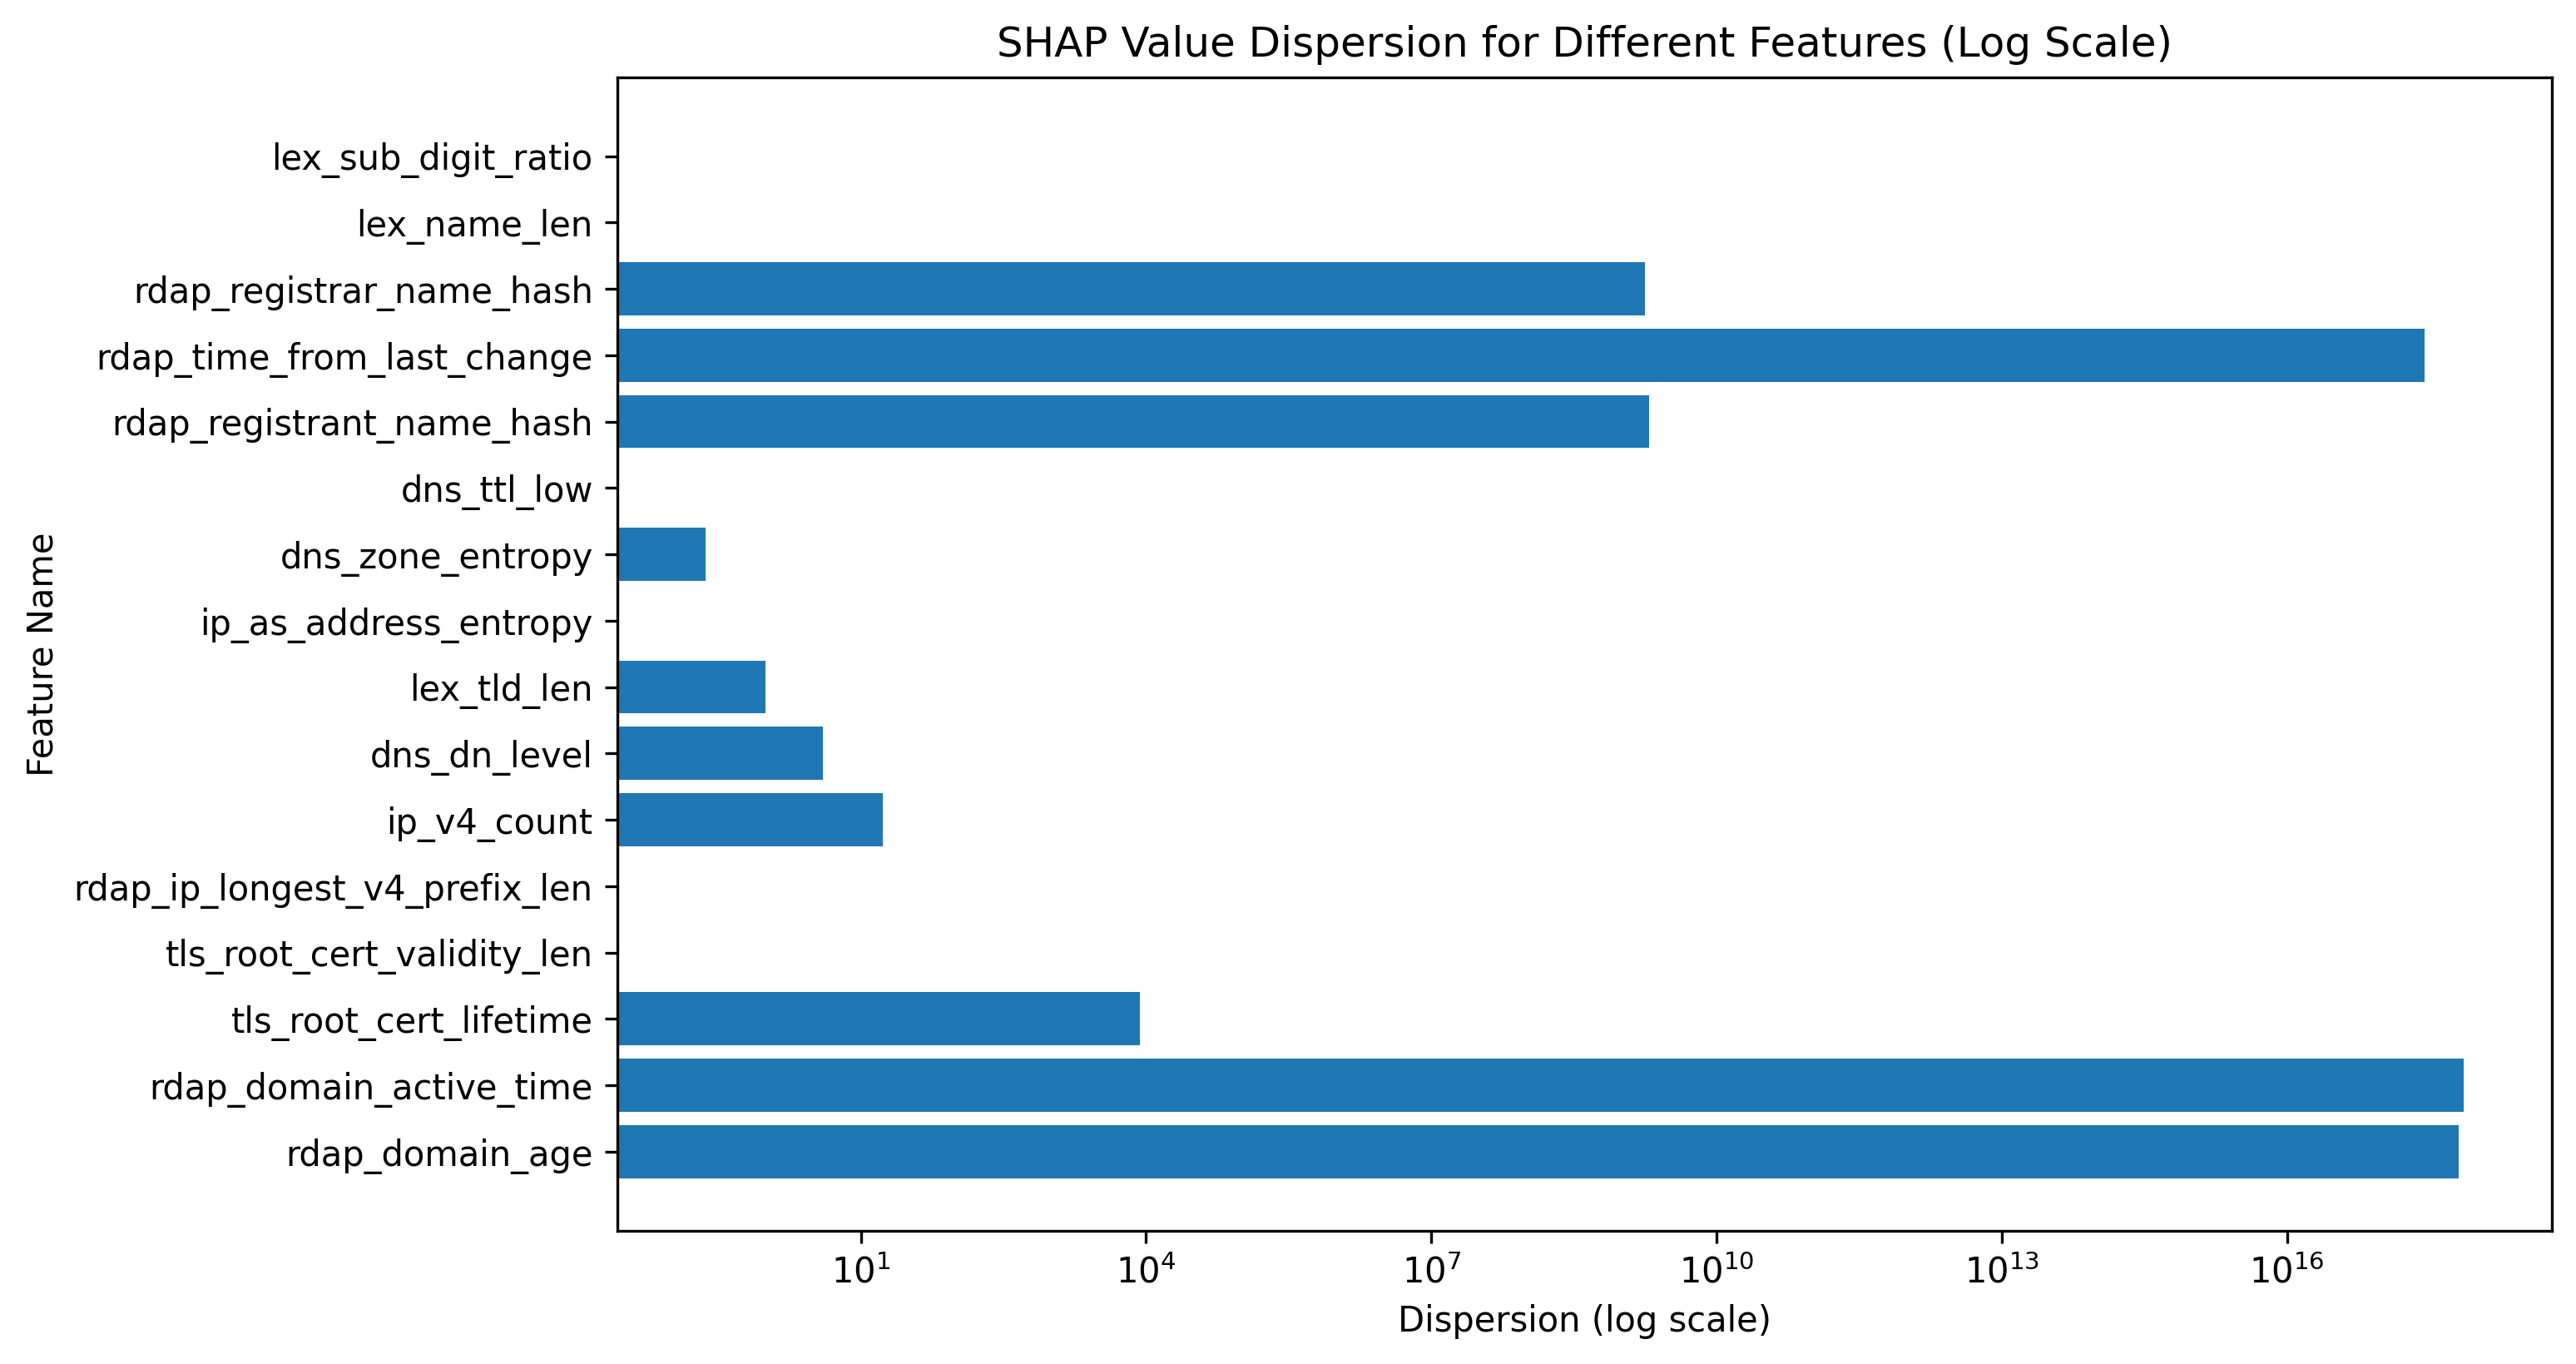

In [ ]:
# calculating dispersions for each feature
dispersions = {}
for feature_name, shap_values in feature_shap_values.items():
    dispersions[feature_name] = max(shap_values) - min(shap_values)

# Create a bar plot to visualize the dispersions
plt.figure(figsize=(10, 6))
plt.barh(list(dispersions.keys()), list(dispersions.values()))
plt.xscale('log')  # Set the x-axis to a logarithmic scale
plt.xlabel('Dispersion (log scale)')
plt.ylabel('Feature Name')
plt.title('SHAP Value Dispersion for Different Features (Log Scale)')
plt.show()


## Merging force plots


In [ ]:
import fitz  # PyMuPDF

# Define the directory containing the PDF files
pdf_dir = "false_positives/force_plots/"

# Create a list to store the paths of PDF files to merge
pdf_files = []

# Iterate through the files in the directory and add PDF files to the list
for filename in os.listdir(pdf_dir):
    if filename.endswith(".pdf"):
        pdf_files.append(os.path.join(pdf_dir, filename))

# Sort the PDF files alphabetically (optional)
pdf_files.sort()

# Initialize a PDF merger object
pdf_merger = fitz.open()

# Merge the PDF files into one
for pdf_file in pdf_files:
    pdf_document = fitz.open(pdf_file)
    pdf_merger.insert_pdf(pdf_document)

# Specify the output PDF file name
output_pdf = "false_positives/merged_force_plots.pdf"

# Save the merged PDF to the output file
pdf_merger.save(output_pdf)

# Close the merger object
pdf_merger.close()

print(f"Successfully merged {len(pdf_files)} PDF files into {output_pdf}")


Successfully merged 608 PDF files into false_positives/merged_force_plots.pdf


# Summary plot
The summary plot shows (in dot or violin mode) how individual feature values are distributed for each feature. The x-axis shows the shap value, while the color shows the feature value. The features are sorted by their importance, so the most important features are at the top. The color indicates the value of the feature. The red color indicates a high value, while the blue color indicates a low value. The zero line is the split point between outputs, just like the base value in the force plot. For some features, you might see that low values usually result in negative classification, while high values usually result in positive classification.

Another mode, bar, shows a mean shap value across all data points, which is effectively a plot of feature importance. Use the widgets to switch between modes and feature count. Also note that the violin and dot plots take a while to calculate, so you might want to start with a low feature count.

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact

import shap
# get shap values (use a smaller sample of the test set if you want to save coffee)
explainer = shap.TreeExplainer(model)
X_sample = X_test
shap_values = explainer.shap_values(X_sample)
# save the values for later use
import pickle
pickle.dump(shap_values, open("shap_values.pickle.dat", "wb"))
plot_type = widgets.RadioButtons(
    options=['dot', 'layered_violin', 'bar'],
    value='layered_violin',
    description='Plot Type:',
    disabled=False
)
max_display = widgets.IntSlider(
    value=10,
    description='Max Display:',
    disabled=False,
    min=1,
    max=len(X_sample.columns)-1
)

@interact
def plot_shap(plot_type=plot_type, max_display=max_display):
        shap.summary_plot(shap_values, X_sample, plot_type=plot_type, class_names=class_map.values(), max_display=max_display, plot_size=[10, max_display])

[13:15:39] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


interactive(children=(RadioButtons(description='Plot Type:', index=1, options=('dot', 'layered_violin', 'bar')…

In [ ]:
# get gain score
score = model.get_booster().get_score(importance_type='gain')
sorted_score = sorted(score.items(), key=lambda x: x[1], reverse=True)
sorted_score

[('ip_v4_count', 343.6308288574219),
 ('rdap_domain_active_time', 169.30990600585938),
 ('dns_trigram_matches', 90.86910247802734),
 ('tls_CA_certs_in_chain_ratio', 70.97160339355469),
 ('tls_broken_chain', 60.40630340576172),
 ('geo_countries_count', 58.35628128051758),
 ('dns_soa_retry', 51.25222396850586),
 ('dns_zone_entropy', 47.569618225097656),
 ('tls_root_cert_lifetime', 38.65937805175781),
 ('rdap_domain_age', 32.974239349365234),
 ('dns_dn_level', 32.211029052734375),
 ('tls_iso_policy_oid', 30.807992935180664),
 ('dns_resolved_record_types', 30.32867431640625),
 ('tls_expired_chain', 29.671356201171875),
 ('dns_SOA_count', 29.105337142944336),
 ('lex_sub_digit_count', 28.58915901184082),
 ('dns_zone_level', 27.165401458740234),
 ('tls_subject_count', 26.377927780151367),
 ('rdap_ip_shortest_v6_prefix_len', 24.803958892822266),
 ('dns_TXT_count', 23.723730087280273),
 ('tls_iso_policy_crt_count', 22.21702003479004),
 ('rdap_registration_period', 21.42056655883789),
 ('dns_AAA

In [ ]:
#print false positives count
print(len(domain_names_dict))

169
